In [3]:
# Import the dataset
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input/"))

import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
torch.__version__

import torch.optim as optim


['pytorch-challange-flower-dataset', 'resnet152flower']


In [4]:
!ls

__notebook_source__.ipynb


In [5]:
# Set Train and Test Directory Variables
TRAIN_DATA_DIR = "../input/pytorch-challange-flower-dataset/flower_data/flower_data/train/"
VALID_DATA_DIR = "../input/pytorch-challange-flower-dataset/flower_data/flower_data/valid/"

In [6]:
!ls -la

total 16
drwxr-xr-x 3 root root 4096 May 22 10:09 .
drwxr-xr-x 6 root root 4096 May 22 10:08 ..
drwxr-xr-x 2 root root 4096 May 22 10:09 .ipynb_checkpoints
-rw-r--r-- 1 root root  199 May 22 10:08 __notebook_source__.ipynb


Class Directory:  33


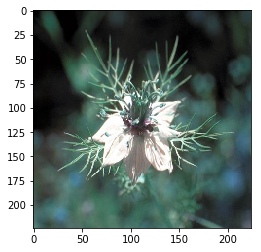

(224, 224, 3)


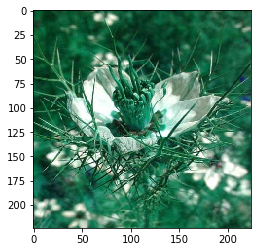

(224, 224, 3)


In [7]:
#Visualiza Some Images of any Random Directory-cum-Class
FILE_DIR = str(np.random.randint(1,103))
print("Class Directory: ",FILE_DIR)
for file_name in os.listdir(os.path.join(TRAIN_DATA_DIR, FILE_DIR))[1:3]:
    img_array = cv2.imread(os.path.join(TRAIN_DATA_DIR, FILE_DIR, file_name))
    img_array = cv2.resize(img_array,(224, 224), interpolation = cv2.INTER_CUBIC)
    plt.imshow(img_array)
    plt.show()
    print(img_array.shape)

In [8]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [9]:
# I used os.listdir() to maintain the ordering 
classes = os.listdir(VALID_DATA_DIR)

In [10]:
def calulate_image_stats(dataset):
    imgs_=torch.stack([img for img,_ in dataset], dim=3)
    imgs_=imgs_.view(3, -1)
    imgs_mean=imgs_.mean(dim=1)
    imgs_std=imgs_.std(dim=1)
    return imgs_mean,imgs_std

d_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor()])
tr_dataset= datasets.ImageFolder(TRAIN_DATA_DIR, transform=d_transforms)

mean_, std_ = calulate_image_stats(tr_dataset)


In [11]:
mean_

tensor([0.4327, 0.3762, 0.2835])

In [12]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ColorJitter(),
                                       transforms.RandomAffine(10),
                                       transforms.RandomVerticalFlip(0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.4327, 0.3762, 0.2835],
                                                            [0.2943, 0.2428, 0.2673])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.4327, 0.3762, 0.2835],
                                                           [0.2943, 0.2428, 0.2673])])

train_data = datasets.ImageFolder(TRAIN_DATA_DIR, transform=train_transforms)
test_data = datasets.ImageFolder(VALID_DATA_DIR, transform=test_transforms)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  6552
Num test images:  818


In [13]:
# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

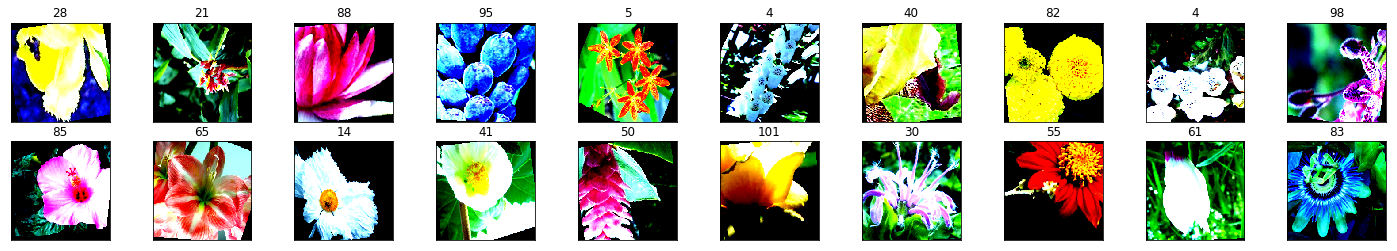

In [14]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [15]:
!ls -la

total 16
drwxr-xr-x 3 root root 4096 May 22 10:09 .
drwxr-xr-x 6 root root 4096 May 22 10:08 ..
drwxr-xr-x 2 root root 4096 May 22 10:09 .ipynb_checkpoints
-rw-r--r-- 1 root root  199 May 22 10:08 __notebook_source__.ipynb


In [16]:
model = models.resnet152(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:02, 81230977.18it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [17]:
for param in model.parameters():
    param.requires_grad = False

    # Freeze training for all "features" layers
#for param in model.features.parameters():
#    param.requires_grad = False

    
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 102)
if train_on_gpu:
    model.cuda()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adadelta(model.parameters(), lr=0.01)


#Load Model State Dictionary from Downloaded model.pt file
Model_State_Path = '../input/resnet152flower/model.pt'
# Convert GPU Model State Dictionary to CPU based
model.load_state_dict(torch.load(Model_State_Path, map_location=lambda storage, loc: storage),strict=False)
#model.eval() #Don't Forget to add this Line

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [19]:
# Define epochs (between 50-200)
epochs = 5
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# Some lists to keep track of loss and accuracy during each epoch
epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
# Start epochs
for epoch in range(epochs):
    
    #adjust_learning_rate(optimizer, epoch)
    
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # Set the training mode ON -> Activate Dropout Layers
    model.train() # prepare model for training
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    # Load Train Images with Labels(Targets)
    for data, target in train_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        if type(output) == tuple:
            output, _ = output
        
        # Calculate Training Accuracy 
        predicted = torch.max(output.data, 1)[1]        
        # Total number of labels
        total += len(target)
        # Total correct predictions
        correct += (predicted == target).sum()
        
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    
    # calculate average training loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Avg Accuracy
    accuracy = 100 * correct / float(total)
    
    # Put them in their list
    train_acc_list.append(accuracy)
    train_loss_list.append(train_loss)
    
        
    # Implement Validation like K-fold Cross-validation 
    
    # Set Evaluation Mode ON -> Turn Off Dropout
    model.eval() # Required for Evaluation/Test

    # Calculate Test/Validation Accuracy         
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:


            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Predict Output
            output = model(data)
            if type(output) == tuple:
                output, _ = output

            # Calculate Loss
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
            # Get predictions from the maximum value
            predicted = torch.max(output.data, 1)[1]

            # Total number of labels
            total += len(target)

            # Total correct predictions
            correct += (predicted == target).sum()
    
    # calculate average training loss and accuracy over an epoch
    val_loss = val_loss/len(test_loader.dataset)
    accuracy = 100 * correct/ float(total)
    
    # Put them in their list
    val_acc_list.append(accuracy)
    val_loss_list.append(val_loss)
    
    # Print the Epoch and Training Loss Details with Validation Accuracy   
    print('Epoch: {} \tTraining Loss: {:.4f}\t Val. acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        accuracy
        ))
    # save model if validation loss has decreased
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_loss))
        # Save Model State on Checkpoint
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = val_loss
    # Move to next epoch
    epoch_list.append(epoch + 1)

Epoch: 1 	Training Loss: 0.3822	 Val. acc: 97.00%
Validation loss decreased (inf --> 0.163237).  Saving model ...
Epoch: 2 	Training Loss: 0.3635	 Val. acc: 97.00%
Validation loss decreased (0.163237 --> 0.151602).  Saving model ...
Epoch: 3 	Training Loss: 0.3621	 Val. acc: 97.00%
Validation loss decreased (0.151602 --> 0.150559).  Saving model ...
Epoch: 4 	Training Loss: 0.3422	 Val. acc: 97.00%
Validation loss decreased (0.150559 --> 0.147634).  Saving model ...
Epoch: 5 	Training Loss: 0.3340	 Val. acc: 97.00%
Validation loss decreased (0.147634 --> 0.140734).  Saving model ...


In [20]:
model.load_state_dict(torch.load('model.pt'))

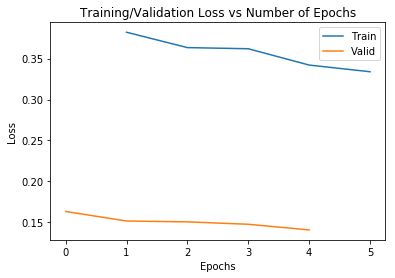

In [21]:
# Training / Validation Loss
plt.plot(epoch_list,train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Validation Loss vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

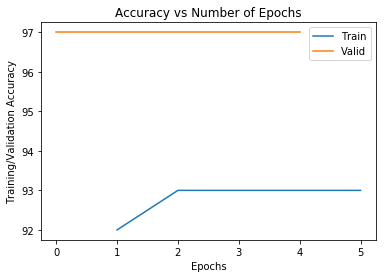

In [22]:
# Train/Valid Accuracy
plt.plot(epoch_list,train_acc_list)
plt.plot(val_acc_list)
plt.xlabel("Epochs")
plt.ylabel("Training/Validation Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='best')
plt.show()

In [23]:
val_acc = sum(val_acc_list[:]).item()/len(val_acc_list)
print("Validation Accuracy of model = {} %".format(val_acc))

Validation Accuracy of model = 97.0 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

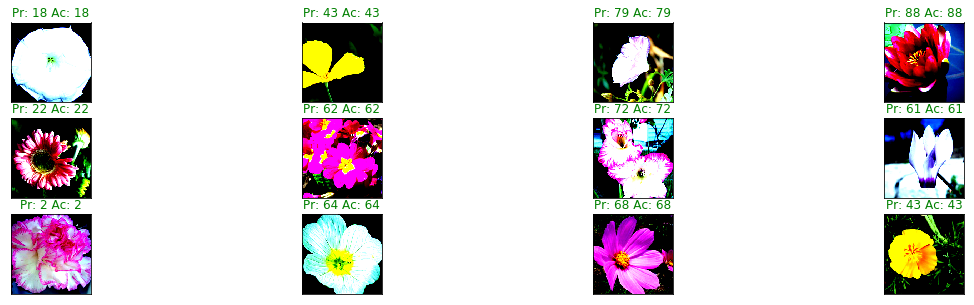

In [24]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

model.eval() # Required for Evaluation/Test
# get sample outputs
output = model(images)
if type(output) == tuple:
            output, _ = output
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 5))
for idx in np.arange(12):
    ax = fig.add_subplot(3, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img[idx], (1, 2, 0)))
    ax.set_title("Pr: {} Ac: {}".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    

In [25]:
!git clone https://github.com/GabrielePicco/deep-learning-flower-identifier
!pip install airtable
import sys
sys.path.insert(0, 'deep-learning-flower-identifier')

Cloning into 'deep-learning-flower-identifier'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 77 (delta 44), reused 29 (delta 4), pack-reused 0
Unpacking objects: 100% (77/77), done.
  Stored in directory: /tmp/.cache/pip/wheels/9b/ba/63/364c02fabcd50ef6e2f101a57feb727bd7a693697765a9df17
Successfully built airtable
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
